# COVID-19 Mortality Data Analysis

## Comprehensive Analysis of Global COVID-19 Mortality Data

In [2]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


Loading data...


<ipython-input-3-823b4383e9f8>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_melted['Date'] = pd.to_datetime(df_melted['Date'])
<ipython-input-3-823b4383e9f8>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_melted['Date'] = pd.to_datetime(df_melted['Date'])
<ipython-input-3-823b4383e9f8>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[


Generating Map Visualizations...



Generating Aggregation Visualizations...


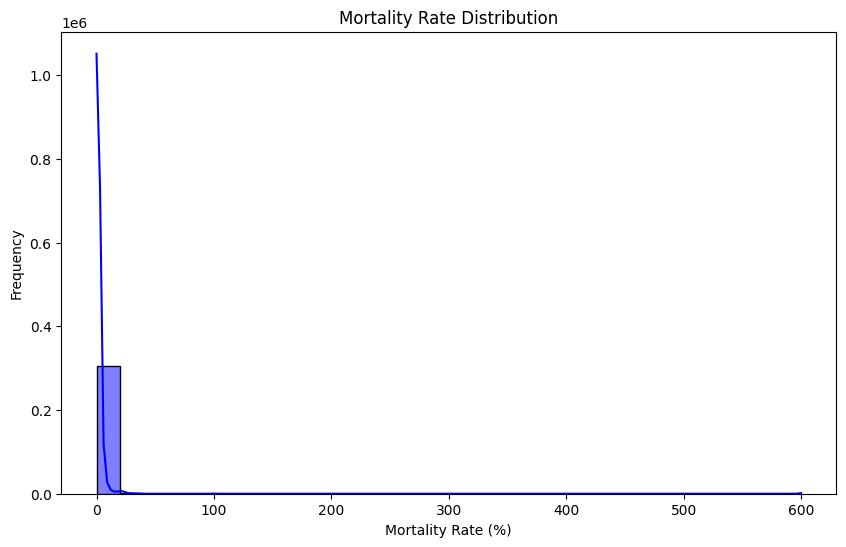

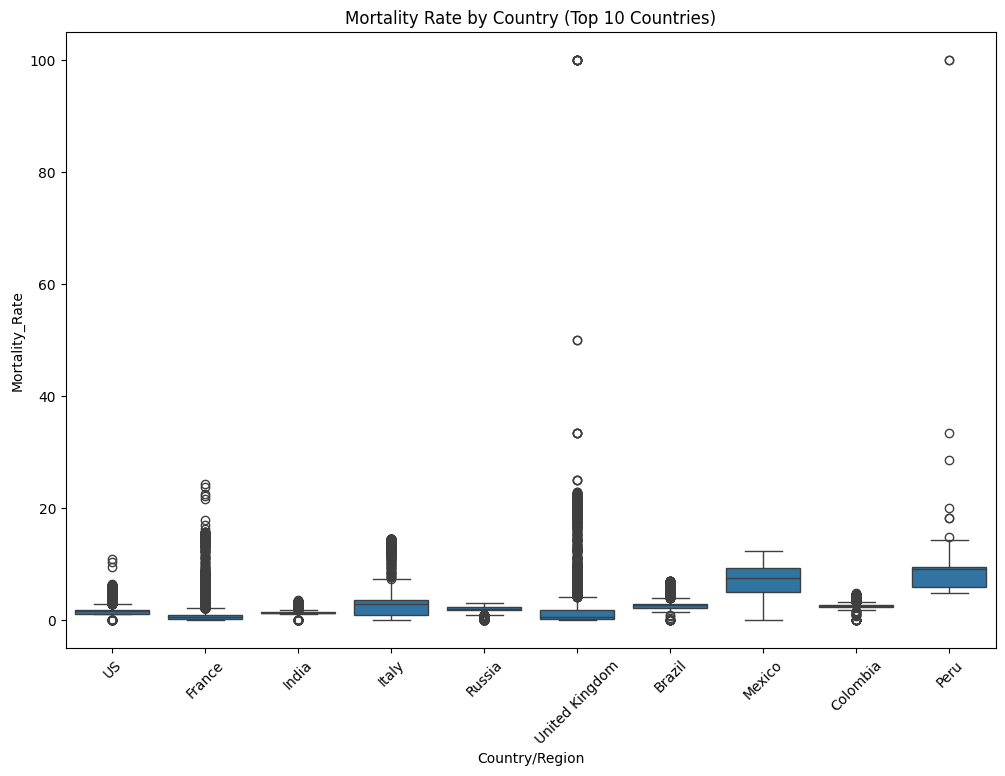


Generating Interactive Visualizations...


<IPython.core.display.Javascript object>

In [3]:
# Install dependencies
!pip install pandas numpy matplotlib seaborn plotly

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

# Load Data
def load_covid_mortality_data():
    """
    Load COVID-19 global mortality data from Johns Hopkins GitHub repository
    """
    confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

    confirmed = pd.read_csv(confirmed_url)
    deaths = pd.read_csv(deaths_url)

    def process_dataframe(df, value_name):
        df_melted = df.melt(
            id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
            var_name='Date',
            value_name=value_name
        )
        df_melted['Date'] = pd.to_datetime(df_melted['Date'])
        return df_melted

    confirmed_long = process_dataframe(confirmed, 'Confirmed')
    deaths_long = process_dataframe(deaths, 'Deaths')

    covid_data = pd.merge(
        confirmed_long,
        deaths_long,
        on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date']
    )

    # Calculate mortality rate
    covid_data['Mortality_Rate'] = covid_data['Deaths'] / covid_data['Confirmed'] * 100
    return covid_data

# Clean Data
def clean_data(df):
    df_cleaned = df[df['Confirmed'] > 0].copy()
    df_cleaned['Mortality_Rate'].fillna(0, inplace=True)
    return df_cleaned

# Choropleth Map
def choropleth_map(df):
    country_data = df.groupby('Country/Region', as_index=False).agg({
        'Deaths': 'sum',
        'Confirmed': 'sum'
    })
    country_data['Mortality_Rate'] = (country_data['Deaths'] / country_data['Confirmed']) * 100

    fig = px.choropleth(
        country_data,
        locations="Country/Region",
        locationmode="country names",
        color="Mortality_Rate",
        hover_name="Country/Region",
        color_continuous_scale="Viridis",
        title="COVID-19 Mortality Rates by Country",
    )
    fig.show()

def bubble_map(df):
    country_data = df.groupby('Country/Region', as_index=False).agg({
        'Deaths': 'sum',
        'Confirmed': 'sum',
        'Lat': 'mean',
        'Long': 'mean',
        'Mortality_Rate': 'mean'  # Include Mortality_Rate in the aggregation
    })
    fig = px.scatter_geo(
        country_data,
        lat='Lat',
        lon='Long',
        size='Deaths',
        color='Mortality_Rate',
        hover_name='Country/Region',
        projection="natural earth",
        title="COVID-19 Deaths and Mortality Rates (Bubble Map)"
    )
    fig.show()

# Density Map
def density_map(df):
    fig = px.density_mapbox(
        df,
        lat="Lat",
        lon="Long",
        z="Deaths",
        radius=10,
        center={"lat": 0, "lon": 0},
        zoom=1,
        mapbox_style="open-street-map",
        title="COVID-19 Death Density"
    )
    fig.show()

# Histogram
def mortality_rate_histogram(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Mortality_Rate'], kde=True, bins=30, color='blue')
    plt.title('Mortality Rate Distribution')
    plt.xlabel('Mortality Rate (%)')
    plt.ylabel('Frequency')
    plt.show()

# Boxplot
def boxplot_mortality(df):
    top_countries = df.groupby('Country/Region')['Deaths'].sum().nlargest(10).index
    df_top_countries = df[df['Country/Region'].isin(top_countries)]

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_top_countries, x='Country/Region', y='Mortality_Rate')
    plt.title('Mortality Rate by Country (Top 10 Countries)')
    plt.xticks(rotation=45)
    plt.show()

# Run All Visualizations
print("Loading data...")
df = load_covid_mortality_data()  # Load data into df
# explore_data(df)
df_cleaned = clean_data(df)

print("\nGenerating Map Visualizations...")
choropleth_map(df_cleaned)
bubble_map(df_cleaned)
density_map(df_cleaned)

print("\nGenerating Aggregation Visualizations...")
mortality_rate_histogram(df_cleaned)
boxplot_mortality(df_cleaned)

print("\nGenerating Interactive Visualizations...")
# Interactive Time-Series Visualization
app = Dash(__name__)

# Get top countries for dropdown options
top_countries = df.groupby('Country/Region')['Deaths'].sum().nlargest(10).index

app.layout = html.Div([
    html.H1("COVID-19 Interactive Dashboard"),

    # Dropdown for Country Selection
    html.Label("Select Country:"),
    dcc.Dropdown(
        id='country-dropdown',
        options=[{'label': country, 'value': country} for country in top_countries],
        value=top_countries[0],  # Default value
        multi=False  # Allow selecting only one country
    ),

    # Radio Buttons for Metric Selection
    html.Label("Select Metric:"),
    dcc.RadioItems(
        id='metric-radio',
        options=[{'label': 'Deaths', 'value': 'Deaths'},
                 {'label': 'Confirmed Cases', 'value': 'Confirmed'},
                 {'label': 'Mortality Rate', 'value': 'Mortality_Rate'}],
        value='Deaths',  # Default value
    ),

    # Graph to display the selected data
    dcc.Graph(id='interactive-chart'),
])

@app.callback(
    Output('interactive-chart', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('metric-radio', 'value')]
)
def update_chart(selected_country, selected_metric):
    filtered_df = df[df['Country/Region'] == selected_country]
    fig = px.line(
        filtered_df,
        x="Date",
        y=selected_metric,  # Use selected metric for y-axis
        title=f"COVID-19 {selected_metric} in {selected_country}",
        labels={"Date": "Date", selected_metric: selected_metric}
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [8]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# ... (Your data loading and processing code) ...

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("COVID-19 Interactive Choropleth Map with Widgets"),

    dcc.Dropdown(
        id='country-dropdown',
        options=[{'label': country, 'value': country} for country in df['Country/Region'].unique()],
        value=None,  # Default: Show all countries
        multi=True  # Allow selecting multiple countries
    ),

    dcc.DatePickerRange(
        id='date-range-picker',
        min_date_allowed=df['Date'].min(),
        max_date_allowed=df['Date'].max(),
        start_date=df['Date'].min(),
        end_date=df['Date'].max(),
    ),

    dcc.Graph(id='choropleth-map'),
])

@app.callback(
    Output('choropleth-map', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('date-range-picker', 'start_date'),
     Input('date-range-picker', 'end_date')]
)
def update_choropleth(selected_countries, start_date, end_date):
    filtered_df = df[
        (df['Date'] >= start_date) &
        (df['Date'] <= end_date)
    ]

    if selected_countries:
        filtered_df = filtered_df[filtered_df['Country/Region'].isin(selected_countries)]

    choropleth_data = filtered_df.groupby('Country/Region', as_index=False).agg(
        {'Deaths': 'sum', 'Confirmed': 'sum'}
    )
    choropleth_data['Mortality_Rate'] = (choropleth_data['Deaths'] / choropleth_data['Confirmed']) * 100

    fig = px.choropleth(
        choropleth_data,
        locations='Country/Region',
        locationmode='country names',
        color='Mortality_Rate',
        hover_name='Country/Region',
        title='COVID-19 Mortality Rates by Country'
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>